In [1]:
import numpy as np
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
import PIL
import tensorflow as tf
import random
import re
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution
#disable_eager_execution()
enable_eager_execution()

In [4]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow_datasets as tfds

In [5]:
from __future__ import print_function
import argparse
from tensorflow.keras.layers import Input
import scipy.misc

from configs import bcolors
from utils import *
import tensorflow_model_optimization as tfmot

# Load Data

In [6]:
BATCH_SIZE = 50
tfds_dataset2, tfds_info  = tfds.load(name='imagenet2012_subset', split='validation[-60%:]', with_info=True,
                                     data_dir='/local/rcs/wei/image_net/') # use the last 20% of images among 50000 validation images for testing
#tf.compat.v1.data.make_one_shot_iterator(tfds_dataset1).get_next()

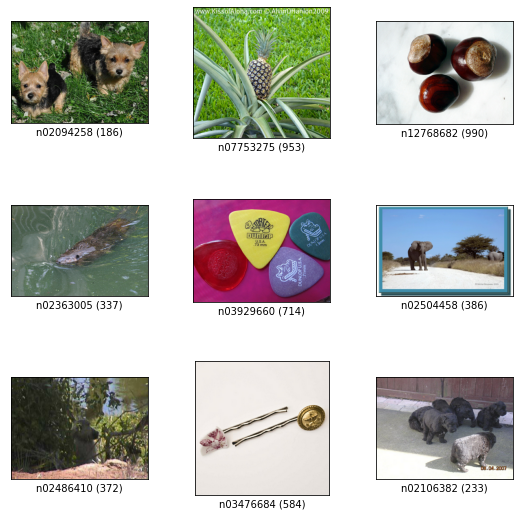

In [7]:
figs = tfds.show_examples(tfds_dataset2, tfds_info)

In [14]:
es = {'file_name': tf.TensorSpec(shape=(), dtype=tf.string, name=None),
 'image': tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None),
 'label': tf.TensorSpec(shape=(), dtype=tf.int64, name=None)}
mydataset = tf.data.experimental.load("/local/rcs/asa97/Final3kImagePerClass/",es).batch(BATCH_SIZE).prefetch(1)

In [15]:
def preprocess_image(features):
    image = features["image"]
    image = tf.image.resize(image,[224,224])
    #image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    features["image"] = image
    return features

In [17]:
val_ds = tfds_dataset2.map(preprocess_image).batch(BATCH_SIZE).prefetch(1)

In [18]:
val_ds = mydataset.batch(BATCH_SIZE).prefetch(1)

In [19]:
for n, features in enumerate(val_ds):
    image = features['image'][0]
    break

In [33]:
image

<tf.Tensor: shape=(50, 224, 224, 3), dtype=float32, numpy=
array([[[[7.53149948e+01, 8.85222778e+01, 2.25039062e+01],
         [6.24579506e+01, 7.83929367e+01, 1.88640194e+01],
         [5.39651604e+01, 7.66612930e+01, 1.15120583e+01],
         ...,
         [3.90779419e+01, 5.99341812e+01, 4.21784019e+00],
         [2.48863106e+01, 4.71098938e+01, 5.22480202e+00],
         [2.66498241e+01, 4.68818474e+01, 1.17201185e+00]],

        [[5.84591064e+01, 7.27944641e+01, 2.26653557e+01],
         [7.38038101e+01, 7.22206039e+01, 1.86153755e+01],
         [6.69349670e+01, 9.29894562e+01, 6.91163111e+00],
         ...,
         [4.12746315e+01, 6.62978516e+01, 1.81876636e+00],
         [3.49127045e+01, 6.06888618e+01, 7.50501394e-01],
         [1.82561321e+01, 3.76593819e+01, 6.35761097e-02]],

        [[6.92024460e+01, 7.41177673e+01, 1.54396133e+01],
         [5.71262131e+01, 6.15114746e+01, 2.77030449e+01],
         [1.02516602e+02, 1.19049324e+02, 3.47850037e+01],
         ...,
         [

In [34]:
preprocess(image)

<tf.Tensor: shape=(50, 224, 224, 3), dtype=float32, numpy=
array([[[[ -81.4351    ,  -28.256721  ,  -48.365005  ],
         [ -85.07498   ,  -38.386063  ,  -61.22205   ],
         [ -92.42694   ,  -40.117706  ,  -69.71484   ],
         ...,
         [ -99.72116   ,  -56.84482   ,  -84.60206   ],
         [ -98.7142    ,  -69.669106  ,  -98.793686  ],
         [-102.76699   ,  -69.897156  ,  -97.030174  ]],

        [[ -81.27365   ,  -43.984535  ,  -65.220894  ],
         [ -85.32362   ,  -44.558395  ,  -49.87619   ],
         [ -97.027374  ,  -23.789543  ,  -56.745033  ],
         ...,
         [-102.12024   ,  -50.481148  ,  -82.405365  ],
         [-103.1885    ,  -56.090137  ,  -88.767296  ],
         [-103.87543   ,  -79.11961   , -105.42387   ]],

        [[ -88.49939   ,  -42.661232  ,  -54.477554  ],
         [ -76.23596   ,  -55.267525  ,  -66.55379   ],
         [ -69.154     ,    2.2703247 ,  -21.163399  ],
         ...,
         [-102.048386  ,  -53.22547   ,  -89.83777   ],

In [21]:
preprocess = tf.keras.applications.resnet.preprocess_input

In [12]:
#preprocess = tf.keras.applications.mobilenet.preprocess_input

In [13]:
#preprocess = tf.keras.applications.densenet.preprocess_input

# Load Model

In [14]:
# input image dimensions
img_rows, img_cols = 224 ,224
input_shape = (img_rows, img_cols, 3)

In [15]:
model_ = tf.keras.applications.ResNet50(input_shape=input_shape)

In [16]:
#model_ = tf.keras.applications.MobileNet(input_shape=input_shape)

In [17]:
#model_ = tf.keras.applications.DenseNet121(input_shape=input_shape)

In [18]:
q_model = tfmot.quantization.keras.quantize_model(model_)

In [19]:
model = tf.keras.applications.ResNet50(input_tensor = q_model.input)

In [20]:
#model = tf.keras.applications.MobileNet(input_tensor = q_model.input)

In [21]:
#model = tf.keras.applications.DenseNet121(input_tensor = q_model.input)

In [22]:
model.load_weights("./fp_model_40_resnet50.h5")
q_model.load_weights("./q_model_40_resnet50.h5")

In [23]:
#model.load_weights("./fp_model_40_mobilenet.h5")
#q_model.load_weights("./q_model_40_mobilenet.h5")

In [24]:
#model.load_weights("./fp_model_40_densenet121.h5")
#q_model.load_weights("./q_model_40_densenet121.h5")

# Display Image

In [25]:
def extract(ith_image,ds, preprocess):
    for i, features in enumerate(ds):
        if ith_image < BATCH_SIZE and i == 0:
            image = preprocess(features["image"][ith_image])[None,...]
            label = features["label"].numpy()[ith_image]
            logits_1 = model(image)
            logits_2 = q_model(image)
            predict_1 = tf.argmax(logits_1, axis=-1).numpy()[0]
            predict_2 = tf.argmax(logits_2, axis=-1).numpy()[0]
            return features["image"][ith_image],image, label,logits_1,logits_2,predict_1,predict_2
        
        elif i == np.floor(ith_image/50):
            image = preprocess(features["image"][ith_image%50])[None,...]
            label = features["label"].numpy()[ith_image%50]
            logits_1 = model(image)
            logits_2 = q_model(image)
            predict_1 = tf.argmax(logits_1, axis=-1).numpy()[0]
            predict_2 = tf.argmax(logits_2, axis=-1).numpy()[0]
            return features["image"][ith_image%50],image, label,logits_1,logits_2,predict_1,predict_2

In [26]:
orig_image,image,label,logits_1,logits_2,predict_1,predict_2 = extract(0,val_ds,preprocess)

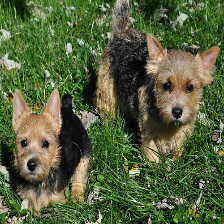

In [27]:
pil_img = tf.keras.preprocessing.image.array_to_img(orig_image)
from IPython.display import Image
display(pil_img)

In [28]:
tf.keras.applications.resnet.decode_predictions(logits_1.numpy(), top=5)[0]

[('n02094258', 'Norwich_terrier', 0.9192168),
 ('n02096294', 'Australian_terrier', 0.07312072),
 ('n02094114', 'Norfolk_terrier', 0.0068597696),
 ('n02097658', 'silky_terrier', 0.00072324334),
 ('n02095570', 'Lakeland_terrier', 5.371283e-05)]

In [29]:
tf.keras.applications.resnet.decode_predictions(logits_2.numpy(), top=5)[0]

[('n02097658', 'silky_terrier', 0.24111614),
 ('n02096294', 'Australian_terrier', 0.24111614),
 ('n02094114', 'Norfolk_terrier', 0.24111614),
 ('n02094258', 'Norwich_terrier', 0.24111614),
 ('n02094433', 'Yorkshire_terrier', 0.018713195)]

In [30]:
#np.save("./trailer_truck.npy",image)

# Baseline: PGD

$ A = argmax_A \,\, [ \,\, L( \,\, model_{quant} \,\, (image + A) , y )\,\, ]$

In [31]:
orig_image,image,label,logits_1,logits_2,predict_1,predict_2 = extract(0,mydataset,preprocess)

In [32]:
grad_iterations = 20
step = 1
epsilon = 8
A = tf.random.normal([224,224,3])

pred1, pred2= model(image), q_model(image)
label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
if label1 != label or label2 != label1:
    print("bad image")

input_image = orig_image
orig_img = tf.identity(input_image)
orig_logist = pred1
orig_label = label

for iters in range(0,grad_iterations):
    with tf.GradientTape() as g:
        g.watch(input_image)
        predict = q_model(preprocess(input_image + A)[None,...])
        final_loss = tf.keras.losses.categorical_crossentropy(orig_logist[0] , predict[0])
        grads = normalize(g.gradient(final_loss, input_image))
    
    A += tf.sign(grads) * step
    A = tf.clip_by_value(A, -epsilon, epsilon)
    test_image_deprocess = tf.clip_by_value(input_image + A, 0, 255)
    test_image = preprocess(test_image_deprocess)[None,...]
    pred1, pred2= model(test_image), q_model(test_image)
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    if not label1 == label2:
        if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0][0][2] > 0.6:
            print("Oh no!")
            A = test_image_deprocess - orig_img
            break

In [47]:
tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0]

[('n01440764', 'tench', 0.999175),
 ('n02514041', 'barracouta', 0.0006368237),
 ('n01632777', 'axolotl', 0.00017723124),
 ('n02641379', 'gar', 8.29589e-06),
 ('n02640242', 'sturgeon', 1.4386211e-06)]

In [48]:
tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0]

[('n01440764', 'tench', 0.04764509),
 ('n01632777', 'axolotl', 0.04764509),
 ('n01631663', 'eft', 0.04764509),
 ('n01630670', 'common_newt', 0.04764509),
 ('n01629819', 'European_fire_salamander', 0.04764509)]

In [34]:
A.numpy()

array([[[ 6., -8., -8.],
        [ 8.,  6., -2.],
        [ 8., -2., -8.],
        ...,
        [-6., -6., -4.],
        [ 7.,  0.,  8.],
        [ 4.,  4.,  4.]],

       [[-8., -8., -8.],
        [-6., -8., -7.],
        [ 7.,  2., -8.],
        ...,
        [-6.,  6.,  4.],
        [-4., -6., -6.],
        [ 6.,  0.,  2.]],

       [[-6.,  2.,  2.],
        [ 6.,  2., -4.],
        [ 6.,  6.,  0.],
        ...,
        [-2.,  4.,  8.],
        [-7., -7., -6.],
        [ 7., -2.,  7.]],

       ...,

       [[ 4.,  7.,  7.],
        [-4.,  0.,  4.],
        [-2.,  2.,  4.],
        ...,
        [-2., -2.,  4.],
        [ 0., -4.,  0.],
        [ 4., -6.,  4.]],

       [[ 0.,  0.,  4.],
        [-4., -2., -4.],
        [ 0., -4.,  6.],
        ...,
        [-2., -2., -2.],
        [ 2.,  4.,  4.],
        [ 0., -6., -4.]],

       [[-2.,  4.,  2.],
        [ 2., -2., -2.],
        [ 0.,  2.,  0.],
        ...,
        [-2., -2., -2.],
        [ 0., -7., -2.],
        [-6., -6., -4.]]

# Generate adverserial example

## 1. A = argmax c*L( q_model(image + A) , sudo_y) -  L( orig_model(image + A) , y) 

In [35]:
#image = np.load("./trailer_truck.npy")

In [46]:
orig_image,image,label,logits_1,logits_2,predict_1,predict_2 = extract(1,mydataset,preprocess)

In [36]:
c = 1e2
grad_iterations = 20
step = 1
epsilon = 8

In [37]:
pred1, pred2= model(image), q_model(image)
label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
if label1 != label or label2 != label1:
    print("bad image")

input_image = orig_image
orig_img = tf.identity(input_image)
orig_label = label
orig_logist = tf.identity(pred1)
A = 0

In [38]:
for iters in range(0,grad_iterations):
    with tf.GradientTape() as g:
        g.watch(input_image)
        processed_img = preprocess(input_image + A)[None,...]
        loss1 = tf.keras.losses.MSE(model(processed_img)[0] , q_model(processed_img)[0])
        # increases this loss, c should be large to make this more importatnt
        loss2 = tf.keras.losses.MSE(orig_logist[0] , model(processed_img)[0])
        # decreases this loss
        final_loss = loss1 - c*loss2
        #print(final_loss)


        grads = normalize(g.gradient(final_loss, input_image))
        
    A += tf.sign(grads) * step
    A = tf.clip_by_value(A, -epsilon, epsilon)
    test_image_deprocess = tf.clip_by_value(input_image + A, 0, 255)
    test_image = preprocess(test_image_deprocess)[None,...]
    pred1, pred2= model(test_image), q_model(test_image)
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    if not label1 == label2:
        print("different")
        if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0][0][2] > 0.6:
            print("Success!")
            A = test_image_deprocess - orig_img
            break

different
Success!


In [39]:
tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0]

[('n01440764', 'tench', 0.9913019),
 ('n07754684', 'jackfruit', 0.0013493106),
 ('n02514041', 'barracouta', 0.0013364687),
 ('n02536864', 'coho', 0.00043267326),
 ('n02321529', 'sea_cucumber', 0.00039673876)]

In [40]:
tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0]

[('n04254680', 'soccer_ball', 0.017607197),
 ('n01440764', 'tench', 0.012916214),
 ('n07615774', 'ice_lolly', 0.011953539),
 ('n07716358', 'zucchini', 0.011062614),
 ('n03494278', 'harmonica', 0.010238091)]

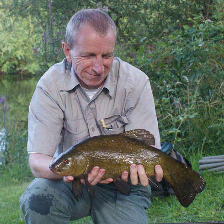

In [41]:
tf.keras.preprocessing.image.array_to_img(test_image_deprocess)

# Transferability

In [103]:
# input image dimensions
img_rows, img_cols = 224 ,224
input_shape = (img_rows, img_cols, 3)
#model__ = ResNet50(input_shape=input_shape)
#t_q_model = tfmot.quantization.keras.quantize_model(model__)
d_model = ResNet50(input_tensor = q_model.input)
d_model.load_weights("./distilled_fp_model_40_resnet50.h5")
#t_q_model.load_weights("./distilled_q_model_40_resnet50.h5")

In [104]:
c = 1e2
grad_iterations = 20
step = 1
epsilon = 8

In [116]:
import time
def topk(model_pred, qmodel_pred, k):
    preds = tf.keras.applications.resnet.decode_predictions(model_pred.numpy(), top=k)
    qpreds = tf.keras.applications.resnet.decode_predictions(qmodel_pred.numpy(), top=1)[0][0][1]
    
    for pred in preds[0]:
        if pred[1] == qpreds:
            return True
    
    return False

def secondk(image,k):
    input_image = tf.convert_to_tensor(orig_image)
    orig_img = tf.identity(input_image)
    
    orig_logist = tf.identity(model(image))
    orig_label =  np.argmax(orig_logist[0])
    
    quant_logist = tf.identity(q_model(image))
    quant_label =  np.argmax(quant_logist[0])

    d_logist = tf.identity(d_model(image))
    d_label =  np.argmax(d_logist[0])

    
    if orig_label != quant_label or orig_label != d_label:
        return -2,-2,-2,-2,-2
    
    A = 0
    start_time = time.time()
    for iters in range(0,grad_iterations):
        with tf.GradientTape() as g:
            g.watch(input_image)
            loss1 = K.mean(d_model(preprocess(input_image+A)[None,...])[..., orig_label])
            loss2 = K.mean(q_model(preprocess(input_image+A)[None,...])[..., orig_label])
            final_loss = K.mean(loss1 - c*loss2)


        grads = normalize(g.gradient(final_loss, input_image))
        A += tf.sign(grads) * step
        A = tf.clip_by_value(A, -epsilon, epsilon)
        test_image_deprocess = tf.cast(tf.clip_by_value(input_image + A, 0, 255),tf.uint8)
        test_image = preprocess(test_image_deprocess)[None,...]
        pred1, pred2= d_model(test_image), q_model(test_image)
        label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
        pred3 = model(test_image)
        label3 = np.argmax(pred3[0])
        
        if not topk(pred1, pred2, k):
            if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=1)[0][0][2] > 0.8:

                if label3 == orig_label and tf.keras.applications.resnet.decode_predictions(pred3.numpy(), top=1)[0][0][2] > 0.6 and not topk(pred3, pred2, k):
                    
                    total_time = time.time() - start_time
                    A = test_image_deprocess - orig_img
                    norm = np.max(np.abs(A))
                
                    return total_time, norm, iters, gen_img_deprocessed, A, label1, label2, label3

                else:
                    return -1, -1, -1, -1, -1, label1, label2, label3

            
    return -1, -1, -1, -1, -1

In [117]:
total_time, norm, iters, gen_img_deprocessed, A, l1,l2,l3 =  secondk(image,5)

In [119]:
total_time, norm, iters, gen_img_deprocessed, A, l1,l2,l3

(-1, -1, -1, -1, -1, 953, 192, 953)

## 2. A = argmax orig_model(image + A)[y] - c*q_model(image + A)[y]

In [169]:
orig_image,image,label,logits_1,logits_2,predict_1,predict_2 = extract(1,val_ds,tf.keras.applications.resnet.preprocess_input)

In [144]:
c = 1
grad_iterations = 20
step = 1
epsilon = 8

input_image = orig_image
orig_img = tf.identity(input_image)
orig_logist = tf.identity(model(image))
orig_label =  np.argmax(orig_logist[0])
A = 0

In [148]:
for iters in range(grad_iterations):
    with tf.GradientTape() as g:
        g.watch(input_image)
        loss1 = K.mean(model(preprocess(input_image + A)[None,...])[..., orig_label])
        loss2 = K.mean(q_model(preprocess(input_image + A)[None,...])[..., orig_label])
        final_loss = K.mean(loss1 - c*loss2)

    grads = normalize(g.gradient(final_loss, input_image))

        # input_image += grads * step    
    A += tf.sign(grads) * step
    A = tf.clip_by_value(A, -epsilon, epsilon)
    test_image_deprocess = tf.clip_by_value(input_image  + A, 0, 255)
    test_image = preprocess(test_image_deprocess)[None,...]
    #test_image_deprocess = deprocess_image_resnet((preprocess(input_image) + A).numpy())
    #test_image = preprocess(test_image_deprocess)[None,...]
            
    pred1, pred2= model(test_image), q_model(test_image)
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    if not label1 == label2:
        print("different")
        if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0][0][2] > 0.6:
            print("Success!")
            A = test_image_deprocess - orig_image
            break

different
Success!


In [149]:
tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.99999857),
 ('n07730033', 'cardoon', 4.7508095e-07),
 ('n07745940', 'strawberry', 2.0066913e-07),
 ('n07753592', 'banana', 1.4546664e-07),
 ('n13133613', 'ear', 1.1145095e-07)]

In [150]:
tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0]

[('n02096177', 'cairn', 0.32410884),
 ('n02097298', 'Scotch_terrier', 0.32410884),
 ('n02097209', 'standard_schnauzer', 0.06372023),
 ('n02091467', 'Norwegian_elkhound', 0.031734284),
 ('n02113712', 'miniature_poodle', 0.027180107)]

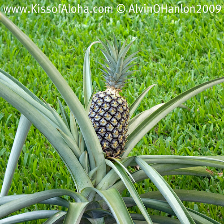

In [151]:
tf.keras.preprocessing.image.array_to_img(test_image_deprocess)

In [142]:
A

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 0., -2.,  0.],
        [-2., -2.,  0.],
        [ 0.,  0.,  2.],
        ...,
        [ 0.,  0.,  2.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 2.,  0.,  0.],
        [-2., -2.,  0.],
        [ 2.,  2.,  2.],
        ...,
        [ 2.,  2.,  2.],
        [ 0.,  0.,  2.],
        [ 0.,  0., -2.]],

       [[ 2., -2.,  0.],
        [ 2., -2.,  2.],
        [ 0., -2.,  2.],
        ...,
        [ 2.,  2.,  2.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       ...,

       [[ 2., -2., -2.],
        [ 0., -2.,  0.],
        [-2.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.],
        [ 0., -2., -2.],
        [ 2.,  0.,  0.]],

       [[ 0.,  2.,  2.],
        [-2., -2., -2.],
        [-2., -2., -2.],
        ...,
        [ 0.,  2.,  2.],
        [ 2.,  0., -2.],
        [ 2.,  0., -2.]],

       [[-2.,  2.,  2.],
        [-2.,  0., -2.],
        [ 0.,  2.,  0.],
        ...,
        [ 2.,  2., 

# 3. Cross Entropy Loss

In [177]:
c = 1
grad_iterations = 20
epsilon = 8
step = 1

pred1, pred2= model(image), q_model(image)
label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
if label1 != label or label2 != label1:
    print("bad image")

input_image = orig_image
orig_img = tf.identity(input_image)
orig_label = label
orig_logist = tf.identity(pred1)
A = 0

In [178]:
for iters in range(0,grad_iterations):
    with tf.GradientTape() as g:
        g.watch(input_image)
        processed_img = preprocess(input_image + A)[None,...]
        loss1 = tf.keras.losses.categorical_crossentropy(model(processed_img)[0] , q_model(processed_img)[0])
        # increases this loss, c should be large to make this more importatnt
        loss2 = tf.keras.losses.categorical_crossentropy(orig_logist[0] , model(processed_img)[0])
        # decreases this loss
        final_loss = loss1 - c*loss2
        #print(final_loss)


        grads = normalize(g.gradient(final_loss, input_image))
        
    A += tf.sign(grads) * step
    A = tf.clip_by_value(A, -epsilon, epsilon)
    test_image_deprocess = tf.clip_by_value(input_image + A, 0, 255)
    test_image = preprocess(test_image_deprocess)[None,...]
    pred1, pred2= model(test_image), q_model(test_image)
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    if not label1 == label2:
        print("different")
        if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0][0][2] > 0.6:
            print("Success!")
            A = test_image_deprocess - orig_img
            break

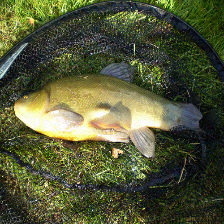

In [179]:
tf.keras.preprocessing.image.array_to_img(test_image_deprocess)